In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Input, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import concatenate

np.random.seed(42)
tf.random.set_seed(42)

2023-12-15 12:00:57.140940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 12:00:57.141206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 12:00:57.191781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 12:00:57.301441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 12:00:58.393008: W tensorflow/compiler/tf2

In [3]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


2023-12-15 12:00:59.640808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:00:59.803634: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:00:59.803697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:01:00.010260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:01:00.010330: I external/local_xla/xla/stream_executor

In [4]:
# Define constants
width, height = 200, 200  # Adjust these dimensions based on your requirements
channels = 1  # 1 for grayscale images, 3 for RGB images
num_classes = 7  # Adjust based on the number of age classes in your dataset
num_epochs = 20
batch_size = 100

In [5]:
combined_faces_zip_path = "./inputs/combined_faces.zip"
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [6]:


combined_faces_zip_path = "./inputs/combined_faces_train_augmented.zip"
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

train_aug_df = pd.read_csv("./inputs/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("./inputs/images_filenames_labels_test.csv")

Done unzipping combined_faces_train_augmented.zip


In [7]:
def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [8]:
train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])
test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

2023-12-15 12:05:31.821812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:05:31.821941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:05:31.822003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:05:31.824623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 12:05:31.824739: I external/local_xla/xla/stream_executor

In [9]:
num_classes = 7
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=channels)
    label = tf.one_hot(label, num_classes)
    return image_decoded, label

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(150)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(150)  

In [10]:
# Defining the architecture of the sequential neural network.
final_cnn = Sequential()
final_cnn.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(width, height, channels)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Flatten())

final_cnn.add(Dense(64, activation='relu'))

final_cnn.add(Dense(num_classes, activation='softmax'))
final_cnn.summary()

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir=f"./outputs/cnn_logs")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 64)        0

In [11]:
checkpoint = ModelCheckpoint(filepath=f"./outputs/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                #   batch_size=512,
                                    batch_size=batch_size,
                                    validation_data=test_dataset,
                                #   epochs=60,
                                    epochs=num_epochs,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False
                                 )

Epoch 1/6


2023-12-15 12:07:06.442592: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-15 12:07:07.652085: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff88cd1aad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 12:07:07.652139: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-12-15 12:07:07.677377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702621327.816742   13067 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - ETA: 0s - loss: 1.5167 - accuracy: 0.5185
Epoch 1: val_accuracy improved from -inf to 0.60422, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 70s 40ms/step - loss: 1.5167 - accuracy: 0.5185 - val_loss: 0.9546 - val_accuracy: 0.6042
Epoch 2/6


/home/bilson/projects/gender-age/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.6150
Epoch 2: val_accuracy improved from 0.60422 to 0.65718, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 61s 39ms/step - loss: 0.9193 - accuracy: 0.6150 - val_loss: 0.8435 - val_accuracy: 0.6572
Epoch 3/6
1105/1563 [====================>.........] - ETA: 16s - loss: 0.8205 - accuracy: 0.6556

1563/1563 [==============================] - ETA: 0s - loss: 0.8081 - accuracy: 0.6618
Epoch 3: val_accuracy improved from 0.65718 to 0.68575, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 59s 37ms/step - loss: 0.8081 - accuracy: 0.6618 - val_loss: 0.7795 - val_accuracy: 0.6857
Epoch 4/6
1563/1563 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.7006
Epoch 4: val_accuracy improved from 0.68575 to 0.71571, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7204 - accuracy: 0.7006 - val_loss: 0.7208 - val_accuracy: 0.7157
Epoch 5/6
1563/1563 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.7328
Epoch 5: val_accuracy improved from 0.71571 to 0.74258, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 59s 37ms/step - loss: 0.6467 - accuracy: 0.7328 - val_loss:

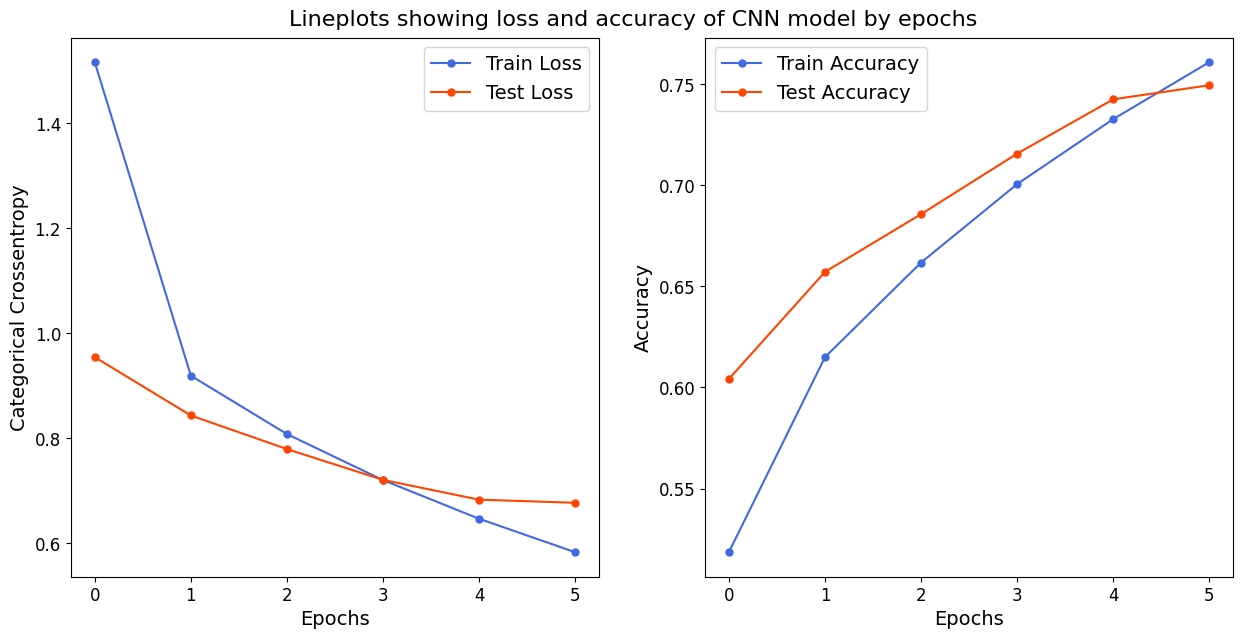

In [12]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

plt.savefig('./outputs/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

67/67 [==============================] - 1s 19ms/step - loss: 0.6771 - accuracy: 0.7496
CNN model loss 		= 0.677
CNN model accuracy 	= 0.75
INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


67/67 [==============================] - 1s 16ms/step
Normalized confusion matrix


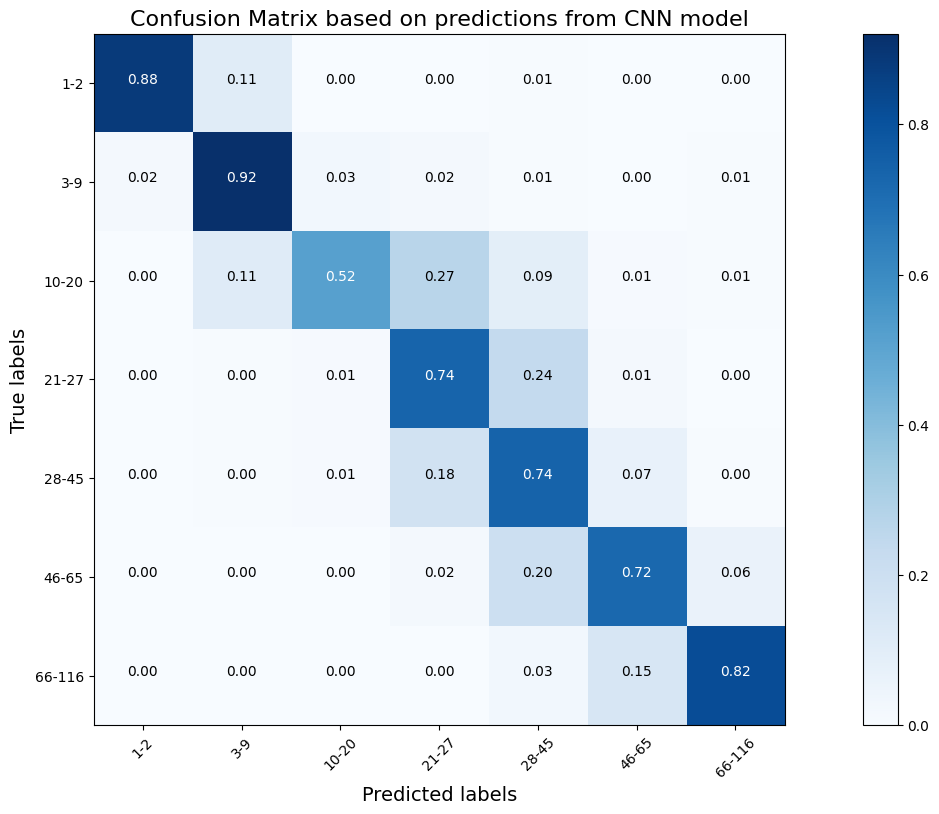

In [13]:
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

final_cnn.save("./saved_model/", save_format='tf')

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    plt.savefig(f'./outputs/cnn_logs/{export_as}.png', bbox_inches='tight');
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()